# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [12]:
#%reset # ensures I am starting from scratch when appending dataframes

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob

import seaborn as sns
sns.set(style="darkgrid")

In [13]:
#set file paths

# path = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/"
# path_raw = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/raw/"
# path_raw_input = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\raw/"
# path_output = "/Users\wb488473\OneDrive - WBG\Documents\GitHub\Disease-Modelling-SSA\data\output/direct_output/sensitivity_analysis/ema_workbench_10m/"

path_mac_iccs_output_5 = "/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/ICCS/5_percent/"
path_mac_iccs_output_25 = "/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/ICCS/25_percent/"



Identify the input files and read them in

### Comparing different seed results on same run
Change the output files to be displayed to those from Sarah

In [14]:


outputFiles = ["myriad_test_agg_5p_v1_0.3_1.txt", "myriad_test_agg_5p_v1_0.3_2.txt", "myriad_test_agg_5p_v1_0.3_3.txt", 
               "myriad_test_agg_5p_v1_0.3_4.txt", "myriad_test_agg_5p_v1_0.3_5.txt", "myriad_test_agg_5p_v1_0.3_6.txt", 
               "myriad_test_agg_5p_v1_0.3_7.txt", "myriad_test_agg_5p_v1_0.3_8.txt", "myriad_test_agg_5p_v1_0.3_9.txt", 
               "myriad_test_agg_5p_v1_0.3_10.txt"] 

import re #enables multiple split criteria in one string


#define the parameters to go into the function
for x in outputFiles :
    exportMe = pd.read_csv(path_mac_iccs_output_5+x, sep='\t')
    exportMe['districtId'] = [int(str(x).split('_')[1]) for x in exportMe["myId"]] 
    exportMe['seed'] = (re.split('agg|.txt', x)[1]) 
    exportMe = exportMe.drop('Unnamed: 10', axis=1)
    exportMe.reset_index(drop=True)
    exportMe.to_csv(path_mac_iccs_output_5+'to_append'+x)

    
seed = '9895'
beta = 0.016
run_length = 180  


# for x in outputFiles:
#     print(x.split('/'))
exportMe.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,districtId,seed
0,0,d_1,0,0,0,5,7,0,0,0,1,_5p_v1_0.3_10
1,1,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_10
2,2,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_10
3,3,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_10
4,4,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_10


In [15]:
#append all files with different seeds outputs together (run at the end when all are created)
exports = glob(path_mac_iccs_output_5+'to_append*')

exports.sort()

iccs_exports = pd.concat((pd.read_csv(export, sep='\t') for export in exports), ignore_index=False)

# export to csv
iccs_exports.to_csv(path_mac_iccs_output_5+'iccs_appended_all_cols.csv', sep='\t')
iccs_exports= pd.read_csv(path_mac_iccs_output_5+'iccs_appended_all_cols.csv', sep=',')

# create a scaled up variable of cases and deaths x20
iccs_exports['scaled_sim_cases']=iccs_exports['metric_new_cases_sympt'] *20
iccs_exports['scaled_sim_deaths']=iccs_exports['metric_new_deaths' ] *20
iccs_exports['scaled_cum_deaths']=iccs_exports['metric_died_count']*20

#ema_exports['metric_died_count'].value_counts()

iccs_exports.head()

,\t,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,districtId,seed,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
0,0\t0,0,d_1,0,0,0,6,6,0,0,0,1,_5p_v1_0.3_1,120,0,0
1,1\t1,1,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
2,2\t2,2,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
3,3\t3,3,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
4,4\t4,4,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0


In [16]:
# create a national level verions with just cases and deaths at seed level
nat_level = iccs_exports.groupby(['time', 'seed']).agg({'metric_new_cases_sympt':np.sum, 'scaled_sim_cases':np.sum, 'metric_died_count':np.sum, 'scaled_cum_deaths':np.sum})
nat_level['metric_died_count']=nat_level['metric_died_count'].astype(int)
nat_level.to_csv(path_mac_iccs_output_5+'nat_level_seeds.csv')
nat_level.head()
iccs_exports.head()

,\t,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,metric_new_recovered,metric_currently_infected,districtId,seed,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
0,0\t0,0,d_1,0,0,0,6,6,0,0,0,1,_5p_v1_0.3_1,120,0,0
1,1\t1,1,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
2,2\t2,2,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
3,3\t3,3,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0
4,4\t4,4,d_1,0,0,0,0,0,0,0,12,1,_5p_v1_0.3_1,0,0,0


### Process aggregate files - (1) tot cases by district over time by seed (2) median tot cases across seeds

In [17]:
# Create a dataset of the total number of cases by seed, by district and by day 
cases_by_dist = iccs_exports.groupby(['seed', 'districtId']).agg({'metric_new_cases_sympt': np.sum, 'metric_new_deaths': np.sum})
cases_by_dist.sort_values(by='districtId')
cases_by_dist_med = cases_by_dist.groupby(['districtId']).agg({'metric_new_cases_sympt': np.median, 'metric_new_deaths':np.median}) # take the median across seeds
cases_by_dist_med.sort_values(by='districtId')


# rename metric_new_cases col to denote it is by district by day for each seed
cases_by_dist.rename(columns={'metric_new_cases_sympt':'sim_tot_cases_dist','metric_new_deaths':'sim_tot_died_dist'}, inplace=True)
# rename metric_new_cases col to denote it is by district by day for each seed
cases_by_dist_med.rename(columns={'metric_new_cases_sympt':'sim_tot_cases_dist_med'}, inplace=True)
cases_by_dist_med.rename(columns={'metric_new_deaths':'sim_tot_deaths_dist_med'}, inplace=True)


#add variables to denote seed of the run, beta value & no. days
files= [cases_by_dist] #,cases_by_dist_med]
for x in files: 
    x ['beta'] = beta
    x ['run_length']= run_length
    x.reset_index(level=['districtId', 'seed'], inplace=True)
    
#generate output files to check 
cases_by_dist.to_csv(path_mac_iccs_output_5+'cases_by_dist.csv')
cases_by_dist_med.to_csv(path_mac_iccs_output_5+'cases_by_dist_med.csv')

#add on the true data 
true_tots= (path+ "../preprocessed/line_list/district_tots_deaths_cases.csv")
true_tots= pd.read_csv(true_tots)
true_tots.rename(columns={'new_district_id':'districtId'}, inplace=True)
true_tots.rename(columns={'tot_cases_by_district':'true_cases_by_dist'}, inplace=True)
true_tots.rename(columns={'tot_deaths_by_district':'true_deaths_by_dist'}, inplace=True)

true_tots.head()

#join true and sim data
dist_true_plus_sim = pd.merge (true_tots,cases_by_dist_med, on = 'districtId', how='outer', validate='one_to_one')
dist_true_plus_sim = dist_true_plus_sim[['districtId', 'district_name_shpfile', 'true_cases_by_dist', 'sim_tot_cases_dist_med', 'true_deaths_by_dist', 'sim_tot_deaths_dist_med']]
dist_true_plus_sim.head()


FileNotFoundError: [Errno 2] File b'/Users\\wb488473\\OneDrive - WBG\\Documents\\GitHub\\Disease-Modelling-SSA\\data\\output/../preprocessed/line_list/district_tots_deaths_cases.csv' does not exist: b'/Users\\wb488473\\OneDrive - WBG\\Documents\\GitHub\\Disease-Modelling-SSA\\data\\output/../preprocessed/line_list/district_tots_deaths_cases.csv'

### Lolipop plots  (maybe scatter after)

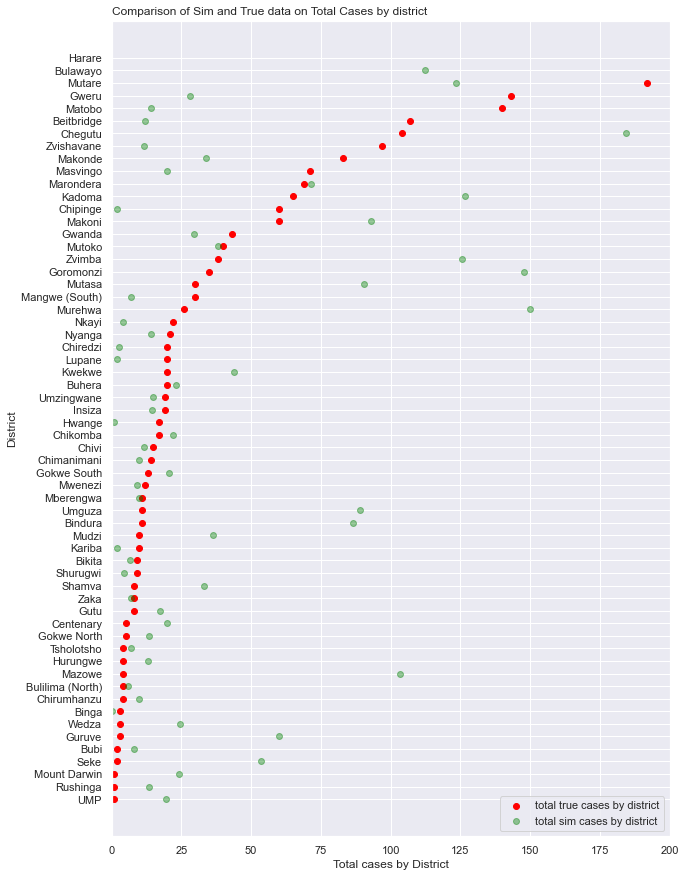

In [35]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_cases_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist_med'], color='grey', alpha=0.4)
plt.scatter(ordered_df['true_cases_by_dist'], my_range, color='red', alpha=1, label='total true cases by district')
plt.scatter(ordered_df['sim_tot_cases_dist_med'], my_range, color='green', alpha=0.4 , label='total sim cases by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and True data on Total Cases by district", loc='left')
plt.xlabel('Total cases by District')
plt.ylabel('District')

#limit range on axis
plt.xlim([0, 200])

# Show the graph
plt.savefig(path+'plots/district/box_plots/tot_cases_dists_sim_vs_true_exclHarare.png')



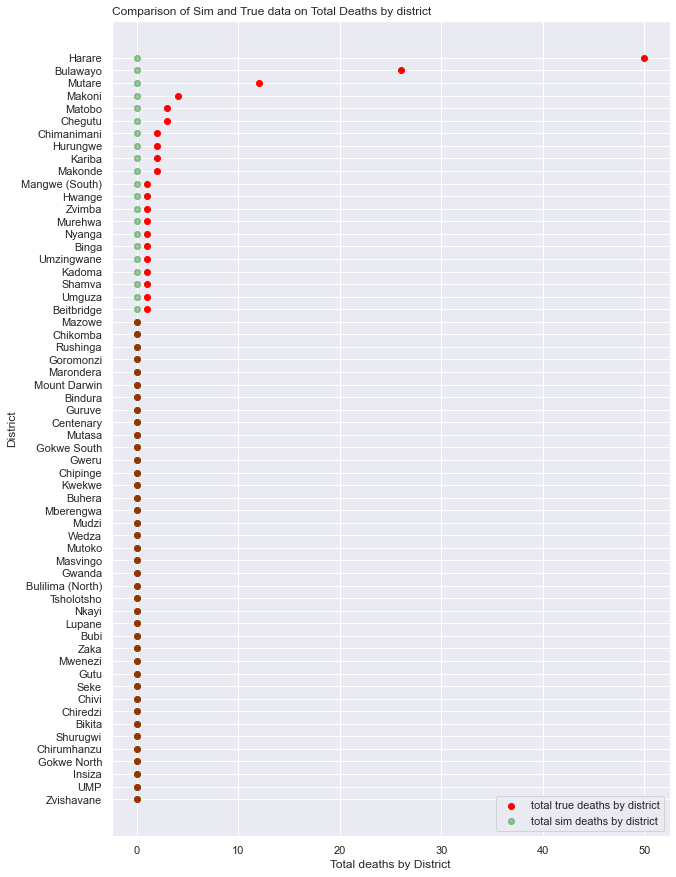

In [36]:
# Reorder it following the values of the first value:
ordered_df = dist_true_plus_sim.sort_values(by='true_deaths_by_dist')
#ordered_df = dist_true_plus_sim[['districtId', 'true_cases_by_dist', 'sim_tot_cases_dist_med']]

my_range=range(1,len(dist_true_plus_sim.index)+1)
fig, ax = plt.subplots (figsize = (10, 15))

# The horizontal plot is made using the hline function
#plt.hlines(y=ordered_df['district_name_shpfile'], xmin=ordered_df['true_cases_by_dist'], xmax=ordered_df['sim_tot_cases_dist_med'], color='grey', alpha=0.4)
plt.scatter(ordered_df['true_deaths_by_dist'], my_range, color='red', alpha=1, label='total true deaths by district')
plt.scatter(ordered_df['sim_tot_deaths_dist_med'], my_range, color='green', alpha=0.4 , label='total sim deaths by district')
plt.legend(loc='lower right')
 
# Add title and axis names
plt.yticks(my_range, ordered_df['district_name_shpfile'])
plt.title("Comparison of Sim and True data on Total Deaths by district", loc='left')
plt.xlabel('Total deaths by District')
plt.ylabel('District')

# Show the graph
plt.savefig(path+'plots/district/box_plots/tot_deaths_dists_sim_vs_true.png')



## Make national level graphs with multiple lines

/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb0b0375310> has a label of '_5p_v1_0.3_1' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb0b0482130> has a label of '_5p_v1_0.3_10' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb08006c520> has a label of '_5p_v1_0.3_2' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)
/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: The han

ValueError: not enough values to unpack (expected 2, got 1)

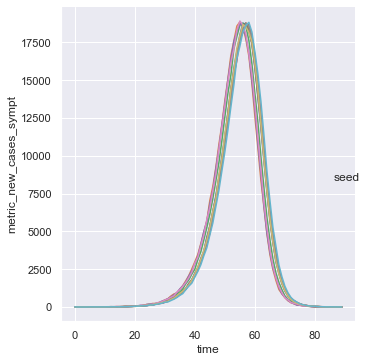

In [18]:
g = sns.relplot(x="time", y="metric_new_cases_sympt", kind="line", hue="seed", ci=None, data=nat_level).set(title="Case projections of 10 runs - before scaling - 5 perc, 0.3 beta")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_10runs_iccs.png')

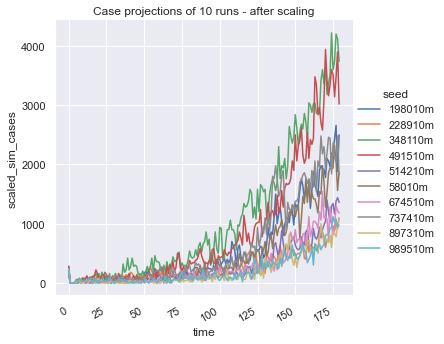

In [37]:
g = sns.relplot(x="time", y="scaled_sim_cases", kind="line", hue="seed", ci=None, data=nat_level).set(title="Case projections of 10 runs - after scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_cases_scaled_10runs.png')

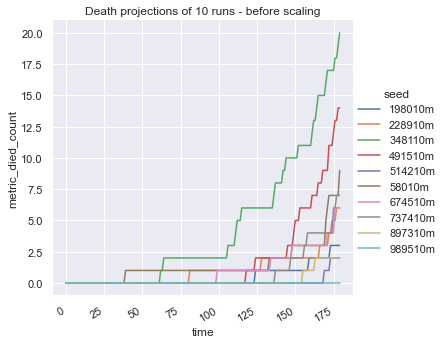

In [38]:
g = sns.relplot(x="time", y="metric_died_count", kind="line", hue="seed", ci=None, data=nat_level).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_10runs.png')

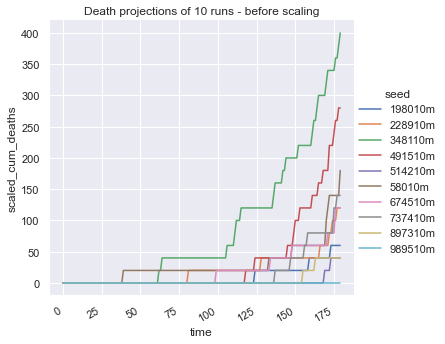

In [39]:
g = sns.relplot(x="time", y="scaled_cum_deaths", kind="line", hue="seed", ci=None, data=nat_level).set(title="Death projections of 10 runs - before scaling")
g.fig.autofmt_xdate()
g.savefig('../data/output/plots/sim_deaths_scaled_10runs.png')

### Process first case files 

In [44]:
# keeping only where the number of either symptomatic or asymptomatic is >0
cases = iccs_exports[(iccs_exports.metric_new_cases_sympt > 0) | (iccs_exports.metric_new_cases_asympt > 0)]
cases = cases.drop('\t', axis=1)
cases.head()


,time,myId,metric_died_count,metric_new_hospitalized,metric_new_critical,metric_new_cases_asympt,metric_new_cases_sympt,metric_new_deaths,districtId,seed,scaled_sim_cases,scaled_sim_deaths,scaled_cum_deaths
3,0,d_48,0,0,0,1,1,0,48,198010m,20,0,0
8,0,d_2,0,0,0,3,5,0,2,198010m,100,0,0
10,0,d_1,0,0,0,2,0,0,1,198010m,0,0,0
31,0,d_18,0,0,0,4,4,0,18,198010m,80,0,0
308,5,d_2,0,0,0,1,0,0,2,198010m,0,0,0


In [45]:
# keep the min time value by district equivalent to first case by district 
first_cases = cases.groupby(['seed','districtId']).agg({'time': 'min'})
first_cases.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
first_cases.rename(columns={'time':'simDay_firstcase'}, inplace=True)

#add variables to denote seed of the run, beta value & no. days
files= [first_cases]
for x in files: 
    x ['beta'] = beta
    x ['run_length']= run_length
    x.reset_index(level=['districtId', 'seed'], inplace=True)

# #create a dataframe of this that I can aggregate afterwards
first_cases.to_csv(path_mac_iccs_output_5+'first_cases_10runs.csv')



In [46]:
# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## this has just made another variable for the true day which is int format 
g_data.head()

,day,districtId,district_name_shpfile,cases_by_district_per_day,tot_cases_by_district,trueDay
0,1,1,Bulawayo,1,1044,1
1,5,18,Goromonzi,1,35,5
2,35,26,Chegutu,3,104,35
3,40,21,Murehwa,1,26,40
4,57,17,Chikomba,1,17,57


In [47]:
# m:1 merge on this data (in true/gold data, we have all 60 districts uniquely)
# note the gold data will get replicated across all 10 seeds if works correctly
# join the simulated and gold standard data based on the district ID
iccs_plus_gold = pd.merge (first_cases, g_data, on = 'districtId', how='outer', validate='many_to_one')
iccs_plus_gold.head(20)

# for the true first days for which there are multiple districts, I need to separate them out. e.g. day 1: Harare=1.1 + Buluwayo=1.2

iccs_plus_gold['trueDay_sep']= iccs_plus_gold['day'].astype(str) + '.'+ iccs_plus_gold['districtId'].astype(str)
iccs_plus_gold['trueDay_sep']= iccs_plus_gold['trueDay_sep'].astype(float)
# for i in ema_plus_gold.day:
#     if i.find([''])

iccs_plus_gold= iccs_plus_gold[['districtId', 'district_name_shpfile',  'trueDay_sep','trueDay','simDay_firstcase', 'seed', 'beta', 'run_length' ]]  #'trueDay_sep',
iccs_plus_gold.to_csv(path_mac_iccs_output_5+'iccs_plus_gold.csv')
iccs_plus_gold.head()

,districtId,district_name_shpfile,trueDay_sep,trueDay,simDay_firstcase,seed,beta,run_length
0,1,Bulawayo,1.1,1,0,198010m,0.016,180
1,1,Bulawayo,1.1,1,0,228910m,0.016,180
2,1,Bulawayo,1.1,1,0,348110m,0.016,180
3,1,Bulawayo,1.1,1,0,491510m,0.016,180
4,1,Bulawayo,1.1,1,0,514210m,0.016,180


## Box plotting the district level comparisons 

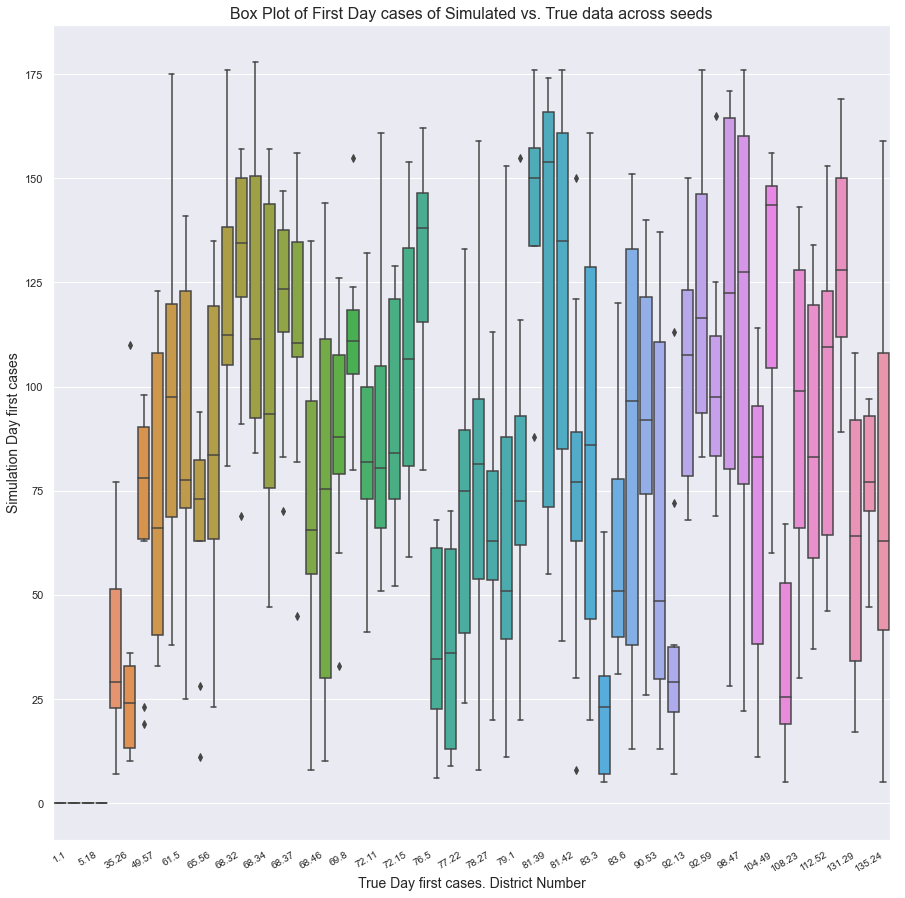

In [48]:
fig, ax = plt.subplots (figsize = (15, 15))
ax = sns.boxplot(
                x='trueDay_sep', 
                y='simDay_firstcase',
                data=iccs_plus_gold)
ax.axes.set_title("Box Plot of First Day cases of Simulated vs. True data across seeds", fontsize=16)
ax.set_xlabel("True Day first cases. District Number", fontsize=14)
ax.set_ylabel("Simulation Day first cases", fontsize=14)


# make sure x axis labels are visible
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, size = 10)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
        
from matplotlib.ticker import FormatStrFormatter
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
#put on same scale
# ax.set(xlim=(0, 179), ylim=(0, 179)) # in true day the max first day is 136, in sim the max first day is 179
# xl, yl = [0,179], [0,179]
# sns.lineplot(xl, yl, linestyle='--', color='red')

# Be sure to only pick integer tick locations.
# import matplotlib.ticker as ticker

# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(path+'plots/district/box_plots/first_cases_dist_10seeds_016_180_incl_asympt.png')
# Nice example code here https://stackabuse.com/seaborn-box-plot-tutorial-and-examples/